# Research Assistant
## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
from dotenv import dotenv_values
secrets=dotenv_values()
from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(
    model="gpt-5",
    azure_deployment="gpt-5",
    api_key=secrets["AZURE_OPENAI_API_KEY"],
    azure_endpoint=secrets["AZURE_OPENAI_ENDPOINT"],
    api_version=secrets["AZURE_OPENAI_API_VERSION"],
    temperature=1
)

c:\Users\kswapnil\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


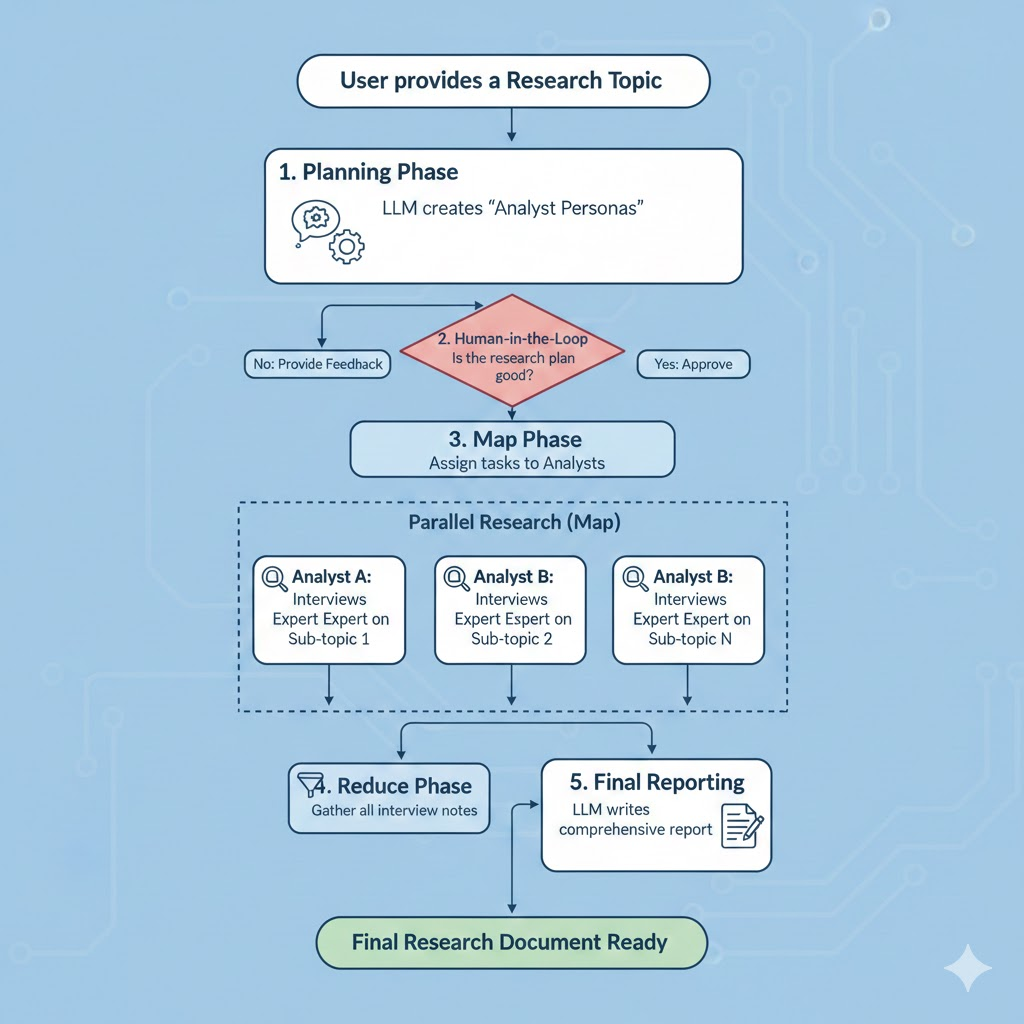

# Create analysts and review them using Human in the Loop

In [2]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel,Field

class Analyst(BaseModel):
    affiliation:str=Field(description="Primary affiliation of the analyst"),
    name:str=Field(description="Name of the Analyst"),
    role:str=Field(description="Role of the Analyst on the context of the topic"),
    description:str=Field(description="Description of the Analyst focus,concerns and motives"),
    @property
    def persona(self) -> str:
        return f"Name :{self.name}\n Role : {self.role} \n Description: {self.description}"
    

class Perspectives(BaseModel):
    analysts:List[Analyst] = Field(description="Comprehensive list of analysts with roles and affiliations")


class GenerateAnalystsState(TypedDict):
    topic:str #ResearchTopic
    max_analysts:int #Number of Analysts
    human_analyst_feedback:str #HumanFeedback
    analysts:List[Analyst] #Analyst asking Questions


In [3]:
from IPython.display import Image,display
from langgraph.graph import START,END,StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

analyst_instructions="""
You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one Indian Name based analyst to each theme.
"""

#Create Analysts Node
def create_analysts(state:GenerateAnalystsState):
    """Create Analysts"""
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback','')

    #StructuredOutput
    structured_llm = llm.with_structured_output(Perspectives)

    #System_Message
    system_message=analyst_instructions.format(topic=topic,max_analysts=max_analysts,human_analyst_feedback=human_analyst_feedback)

    #Generate a Question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate a set of analysts")])

    #Return the set of analysts
    return{"analysts":analysts.analysts}


#Human Feeback Node
def human_feedback(state:GenerateAnalystsState):
    """ No Operations Node it should be interrupted on"""
    pass

#Should Continue Node
def should_continue(state:GenerateAnalystsState):
    "Return the next node to execute"
    #Check if Human feeback exists
    human_analyst_feedback=state.get('human_analyst_feedback',None)
    if human_analyst_feedback:
        return "create_analysts"
    else:
        return END

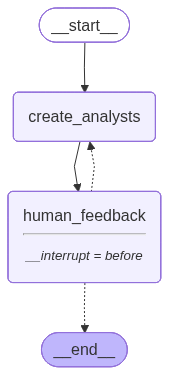

In [4]:
#BUILDING NODES AND EDGES
builder=StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts",create_analysts)
builder.add_node("human_feedback",human_feedback)
builder.add_edge(START,"create_analysts")
builder.add_edge("create_analysts","human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts",END])

#compiling the graph
memory=MemorySaver()
graph=builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

#Display the Graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
#PROVIDE INPUTS TO THE GRAPH
max_analysts=3
topic="The benefits of adopting langgraph as an Agent Framework"
thread={"configurable":{"thread_id":"1"}}

In [6]:
#RUN THE GRAPH UNTIL FIRST INTERRUPT
for event in graph.stream({"topic":topic,"max_analysts":max_analysts},thread,stream_mode="values"):
    #Review
    analysts=event.get('analysts','')
    if analysts:
        for analyst in analysts:
            print("*"*50)
            print(f"Name:{analyst.name}")
            print(f"Affiliation:{analyst.affiliation}")
            print(f"Role:{analyst.role}")
            print(f"Description:{analyst.description}")
            print("*"*50)


c:\Users\kswapnil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Primary affiliation of the analyst'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
c:\Users\kswapnil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Name of the Analyst'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
c:\Users\kswapnil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Role of the Analyst on the context o

**************************************************
Name:Ananya Rao
Affiliation:Nirman AI Advisory
Role:Reliability and Deterministic Control for Agent Workflows
Description:Analyzes how LangGraph’s stateful graphs, typed state, and checkpointing improve reliability, reproducibility, and auditability versus alternative agent frameworks. Focuses on error handling, retries, guardrails, validation schemas, and governance patterns to reduce nondeterminism. Delivers best-practice architectures (DAGs, subgraphs, tool contracts), metrics frameworks (failure rate, MTTR, reproducibility index), and migration guidance for teams seeking predictable, compliant agent behavior.
**************************************************
**************************************************
Name:Vikram Iyer
Affiliation:Delhi Institute of AI Systems
Role:Multi‑Agent Orchestration and Collaboration Patterns
Description:Explores LangGraph’s benefits for composing multi-agent systems, including planner–solver–critic 

In [7]:
# Get state and look at next node
state = graph.get_state(thread)
print(state.next)

('human_feedback',)


In [8]:
#Providing Human Feedback to the graph
graph.update_state(thread,{"human_analyst_feedback":"add someone from a startup to add an entrepreneur perspective"},as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e7aa6-216f-6864-8002-f642ec8d8fa0'}}

In [ ]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    node_name = next(iter(event.keys()))
    print(node_name)
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print("-" * 50) 
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

--------------------------------------------------
Name: Ananya Rao
Affiliation: Nirman AI Advisory
Role: Reliability and Deterministic Control for Agent Workflows
Description: Analyzes how LangGraph’s stateful graphs, typed state, and checkpointing improve reliability, reproducibility, and auditability versus alternative agent frameworks. Focuses on error handling, retries, guardrails, validation schemas, and governance patterns to reduce nondeterminism. Delivers best-practice architectures (DAGs, subgraphs, tool contracts), metrics frameworks (failure rate, MTTR, reproducibility index), and migration guidance for teams seeking predictable, compliant agent behavior.
--------------------------------------------------
--------------------------------------------------
Name: Vikram Iyer
Affiliation: Delhi Institute of AI Systems
Role: Multi‑Agent Orchestration and Collaboration Patterns
Description: Explores LangGraph’s benefits for composing multi-agent systems, including planner–solver

c:\Users\kswapnil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Primary affiliation of the analyst'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
c:\Users\kswapnil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Name of the Analyst'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
c:\Users\kswapnil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Role of the Analyst on the context o

--------------------------------------------------
Name: Dr. Ananya Iyer
Affiliation: IIT Bombay, Center for AI Systems
Role: Theme Lead: Reliability, Observability, and Governance
Description: Focuses on how LangGraph’s explicit state graphs and checkpoints improve determinism, reproducibility, and failure recovery in agent workflows. Emphasizes benefits like traceability via integrations (e.g., tracing/telemetry), audit-friendly execution histories, and structured error handling with interrupt/human-in-the-loop steps. Advocates for typed state and clearly defined transitions to reduce hidden side effects and make compliance reviews simpler. Positions LangGraph as a framework that turns LLM agents from ad‑hoc scripts into well-governed, testable systems.
--------------------------------------------------
--------------------------------------------------
Name: Ravi Menon
Affiliation: Infosys, Principal Architect – AI Platforms
Role: Theme Lead: Multi‑Agent Design and Orchestration
Des

In [10]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e7ab1-cda0-62d7-8004-bae5b656fbb6'}}

In [11]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)


In [14]:
#Check whether have we reached the end of graph execution
final_state.next

()

In [15]:
analysts = final_state.values.get('analysts')
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Ananya Iyer
Affiliation: IIT Bombay, Center for AI Systems
Role: Theme Lead: Reliability, Observability, and Governance
Description: Focuses on how LangGraph’s explicit state graphs and checkpoints improve determinism, reproducibility, and failure recovery in agent workflows. Emphasizes benefits like traceability via integrations (e.g., tracing/telemetry), audit-friendly execution histories, and structured error handling with interrupt/human-in-the-loop steps. Advocates for typed state and clearly defined transitions to reduce hidden side effects and make compliance reviews simpler. Positions LangGraph as a framework that turns LLM agents from ad‑hoc scripts into well-governed, testable systems.
--------------------------------------------------
Name: Ravi Menon
Affiliation: Infosys, Principal Architect – AI Platforms
Role: Theme Lead: Multi‑Agent Design and Orchestration
Description: Explores how LangGraph enables composition of specialized agents into collaborative workflow